In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
#import mutagen
import os
import random
import wave
import numpy as np
from scipy.io.wavfile import read as read_wav
from scipy.io.wavfile import write as write_wav
import librosa
import librosa.display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

import utils
import classifier

In [30]:
df = utils.load_wav_dataset("IRMAS-TrainingData")

Processing directory 1
100%
Processing directory 2
10.0%
20.0%
30.000000000000004%
40.0%
50.0%
60.0%
70.0%
80.0%
89.99999999999999%
100%
Processing directory 3
10.0%
20.0%
30.000000000000004%
40.0%
50.0%
60.0%
70.0%
80.0%
89.99999999999999%
100%
Processing directory 4
10.0%
20.0%
30.000000000000004%
40.0%
50.0%
60.0%
70.0%
80.0%
89.99999999999999%
100%
Processing directory 5
10.0%
20.0%
30.000000000000004%
40.0%
50.0%
60.0%
70.0%
80.0%
89.99999999999999%
100%
Processing directory 6
10.0%
20.0%
30.000000000000004%
40.0%
50.0%
60.0%
70.0%
80.0%
89.99999999999999%
100%
Processing directory 7
10.0%
20.0%
30.000000000000004%
40.0%
50.0%
60.0%
70.0%
80.0%
89.99999999999999%
100%
Processing directory 8
10.0%
20.0%
30.000000000000004%
40.0%
50.0%
60.0%
70.0%
80.0%
89.99999999999999%
100%
Processing directory 9
10.0%
20.0%
30.000000000000004%
40.0%
50.0%
60.0%
70.0%
80.0%
89.99999999999999%
100%
Processing directory 10
10.0%
20.0%
30.000000000000004%
40.0%
50.0%
60.0%
70.0%
80.0%
89.99999999999

In [31]:
df.head(5)

,file,dir,root,rate,data,nframes,nchannels,label,instruments
0,008__[cel][nod][cla]0058__1.wav,[],C:\Users\conno\Desktop\cs230_Project\IRMAS-Tra...,44100,"[[[-36.08800553595013, -31.451517043505582], [...",132299,2,"[[1], [0], [0], [0], [0], [0], [0], [0], [0], ...",cel
1,008__[cel][nod][cla]0058__2.wav,[],C:\Users\conno\Desktop\cs230_Project\IRMAS-Tra...,44100,"[[[-62.457555551075544, -52.239983398821295], ...",132299,2,"[[1], [0], [0], [0], [0], [0], [0], [0], [0], ...",cel
2,008__[cel][nod][cla]0058__3.wav,[],C:\Users\conno\Desktop\cs230_Project\IRMAS-Tra...,44100,"[[[-40.52726728660376, -50.15439587549129], [-...",132299,2,"[[1], [0], [0], [0], [0], [0], [0], [0], [0], ...",cel
3,012__[cel][nod][cla]0043__1.wav,[],C:\Users\conno\Desktop\cs230_Project\IRMAS-Tra...,44100,"[[[-56.93196448531186, -43.51296443035529], [-...",132299,2,"[[1], [0], [0], [0], [0], [0], [0], [0], [0], ...",cel
4,012__[cel][nod][cla]0043__2.wav,[],C:\Users\conno\Desktop\cs230_Project\IRMAS-Tra...,44100,"[[[-50.70497363263279, -68.65606369870291], [-...",132299,2,"[[1], [0], [0], [0], [0], [0], [0], [0], [0], ...",cel


(128, 259, 2)


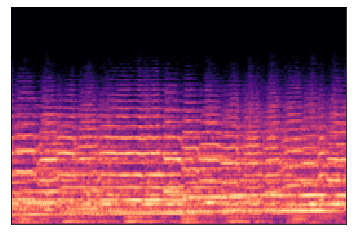

In [32]:
sample = df.sample(n=1).iloc[0]
print(sample.data.shape)
librosa.display.specshow(sample.data[:,:,0])

In [33]:
df = df.sample(frac=1)

In [36]:
model = classifier.make_model()

train_set = df.tail(-1000)
test_set = df.head(1000)
classifier.train_model(model, train_set, batch_size=32, epochs=20)


Epoch 1/20
179/179 [==============================] - 9s 45ms/step - loss: 10.3878
Epoch 2/20
179/179 [==============================] - 8s 44ms/step - loss: 1.9388
Epoch 3/20
179/179 [==============================] - 8s 43ms/step - loss: 1.6666
Epoch 4/20
179/179 [==============================] - 8s 43ms/step - loss: 1.3669
Epoch 5/20
179/179 [==============================] - 8s 44ms/step - loss: 1.0892
Epoch 6/20
179/179 [==============================] - 8s 44ms/step - loss: 0.8125
Epoch 7/20
179/179 [==============================] - 8s 45ms/step - loss: 0.6024
Epoch 8/20
179/179 [==============================] - 9s 49ms/step - loss: 0.3936
Epoch 9/20
179/179 [==============================] - 9s 51ms/step - loss: 0.2656
Epoch 10/20
179/179 [==============================] - 10s 54ms/step - loss: 0.1606
Epoch 11/20
179/179 [==============================] - 9s 53ms/step - loss: 0.1159
Epoch 12/20
179/179 [==============================] - 9s 52ms/step - loss: 0.0869
Epoch 13/20

In [37]:
train_acc, test_acc = classifier.get_accuracy(model, train_set), classifier.get_accuracy(model, test_set)
print("Train accuracy:", train_acc, " Test accuracy:", test_acc)

Train accuracy: 0.9956178790534619  Test accuracy: 0.415


In [48]:
song_data_0 = utils.load_song("brooklyn_sax.wav")
song_data_1 = utils.load_song("brooklyn_band.wav")
print(song_data_0.shape)
print(song_data_1.shape)

(128, 33169, 2)
(128, 37347, 2)


In [53]:
output = classifier.predict_song(model, song_data_1, stride=250)
print(np.argmax(output, axis=1))

[6 2 6 6 6 7 6 6 6 7 0 4 6 8 6 7 6 6 6 4 6 6 9 9 2 6 4 2 7 6 3 0 8 6 6 4 0
 6 4 6 9 7 6 9 4 7 0 9 7 0 4 2 0 9 6 6 0 0 0 0 7 9 6 6 4 6 0 0 0 0 6 6 7 0
 4 2 9 0 7 0 7 4 4 0 0 9 0 7 7 4 4 0 0 0 0 4 0 0 0 6 0 6 6 6 4 9 0 0 9 4 6
 0 9 6 6 7 7 6 6 0 0 0 6 6 4 7 6 8 9 7 4 0 7 4 9 9 6 9 2 6 0 0 0 0 6 9 7 0]


In [14]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=8, kernel_size=4, strides=(2,2), padding='same', input_shape=(128,259,1), name="conv_1"))
model.add(tf.keras.layers.BatchNormalization(axis=1, name="bn_1"))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name="mpool_1"))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(1,1), padding='valid', name="conv_2"))
model.add(tf.keras.layers.BatchNormalization(axis=1, name="bn_2"))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name="mpool_2"))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=(1,1), padding='valid', name="conv_3"))
model.add(tf.keras.layers.BatchNormalization(axis=1, name="bn_3"))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name="mpool_3"))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(500, activation='relu', name="fc_4"))
model.add(tf.keras.layers.Dense(11, activation=None, name="fc_5"))
model.add(tf.keras.layers.Softmax())

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy())

train_set = df.tail(-1000)
test_set = df.head(1000)

x, y = np.stack(train_set.data), np.stack(train_set.label)
x = x.reshape((-1,128,259,1))
print(x.shape)
print(x.shape, y.shape)

model.fit(x, y, batch_size=32, epochs=30)

'''x, y = np.stack(sample['data']), np.stack(sample['label'])
print(x.shape, y.shape)
print(type(x), type(y))
x, y = tf.convert_to_tensor(x, dtype=tf.float32), tf.convert_to_tensor(y, dtype=tf.float32)
model.predict(x)'''

(5705, 128, 259, 1)
(5705, 128, 259, 1) (5705, 11, 1)
Epoch 1/30
179/179 [==============================] - 17s 91ms/step - loss: 2.8867
Epoch 2/30
179/179 [==============================] - 18s 99ms/step - loss: 2.0963
Epoch 3/30
179/179 [==============================] - 18s 103ms/step - loss: 1.8531
Epoch 4/30
179/179 [==============================] - 18s 103ms/step - loss: 1.6825
Epoch 5/30
179/179 [==============================] - 19s 104ms/step - loss: 1.5492
Epoch 6/30
179/179 [==============================] - 19s 104ms/step - loss: 1.4382
Epoch 7/30
179/179 [==============================] - 19s 105ms/step - loss: 1.2899
Epoch 8/30
179/179 [==============================] - 19s 108ms/step - loss: 1.1638
Epoch 9/30
179/179 [==============================] - 19s 106ms/step - loss: 1.0388
Epoch 10/30
179/179 [==============================] - 19s 104ms/step - loss: 0.9055
Epoch 11/30
179/179 [==============================] - 19s 104ms/step - loss: 0.8064
Epoch 12/30
179/179 [=

"x, y = np.stack(sample['data']), np.stack(sample['label'])\nprint(x.shape, y.shape)\nprint(type(x), type(y))\nx, y = tf.convert_to_tensor(x, dtype=tf.float32), tf.convert_to_tensor(y, dtype=tf.float32)\nmodel.predict(x)"

In [15]:
x, y = np.stack(train_set.data), np.stack(train_set.label)
x = x.reshape((-1,128,259,1))

preds = np.argmax(model.predict(x), axis=1).reshape(x.shape[0], 1)
true = np.argmax(y, axis=1)

print("Train accuracy:", np.sum((preds == true)*np.ones(preds.shape))/x.shape[0])

Train accuracy: 0.9815950920245399


In [16]:
x, y = np.stack(test_set.data), np.stack(test_set.label)
x = x.reshape((-1,128,259,1))

preds = np.argmax(model.predict(x), axis=1).reshape(x.shape[0], 1)
true = np.argmax(y, axis=1)

print("Test accuracy:", np.sum((preds == true)*np.ones(preds.shape))/x.shape[0])

Test accuracy: 0.5


In [11]:
#15 epochs - train 88.0 test 51.5


#30 epochs - train accuracy 96.7%, test accuracy 36.8%
#20 epochs - train accuracy 98.8%, test accuracy 47.8%
#15 epochs - train accuracy 97.5%, test accuracy 36.4%
#10 epochs - train accuracy 95.7%, test accuracy 44.4%

arr = np.array([[5, 2], [3, 4], [6, 8]])
print (arr)
print (np.linalg.norm(arr))
print (arr / np.linalg.norm(arr))

[[5 2]
 [3 4]
 [6 8]]
12.409673645990857
[[0.40291148 0.16116459]
 [0.24174689 0.32232919]
 [0.48349378 0.64465837]]


In [15]:
utils.combine_dataset(df, 5, 3)

,rate,data,nframes,nchannels
0,44100,"[[-0.000395372563721885, 0.0002594891336093784...",132299,2
1,44100,"[[3.549788664473761e-06, -0.000188425086505086...",132299,2
2,44100,"[[0.001993880217227438, 0.0008094030453297519]...",132299,2
3,44100,"[[0.002338955036257632, 0.003134942416460479],...",132299,2
4,44100,"[[0.00021759386255007921, 0.000870578669605758...",132299,2
